# Задача: Определить выбор локации для скважины

Общий прицип  для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats as st

sns.set_style("darkgrid")
pd.options.display.float_format = '{:,.2f}'.format
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
BUDGET=10**10  #Бюджет на разработку скважин в регионе — 10 млрд рублей.
NUMBER_WELL = 200 #c помощью машинного обучения выбирают 200 лучших для разработки
GROSS_INCOME = 450*1000 #доход с каждой единицы продукта составляет 450 тыс. рублей
SEARCH_WELL = 500 #при разведке региона исследуют 500 точек

## Загрузка и подготовка данных

###  Взгляд на данные, структура и пропуски

In [3]:
data_list=[]
for i in range(3):
    exec('data_'+str(i)+ "=pd.read_csv('/datasets/geo_data_"+str(i)+".csv')")
    exec(f'display(data_{i}.head())')
    exec(f'data_{i}.info()')
    exec(f'data_list.append(data_{i})')
    print('\n', '====='*20, '\n')

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB




,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB




,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB




**Вывод:** с данными все окей, предварительно чистые и не имеют пропусков, имеют одинаковый размер

### Оценка частотного распределения данных

Оценим, как распределились частоты по критериям, так как предполагаем, что выбросы могут сильно влиять на среднее значение.

In [4]:
title_hist = ['Регион_1','Регион_2','Регион_3']
list_columns = data_list[1].columns 
list_columns = list_columns.drop('id')

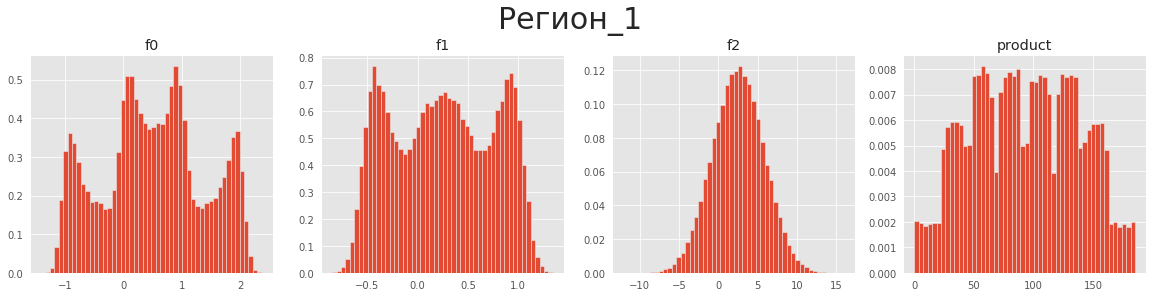

In [5]:
region = 0
num_bins = 50
fig, ax = plt.subplots(1,4, figsize=(20, 4))
fig.suptitle(title_hist[region] ,y = 1.05,fontsize = 30)

for i in range(4):
    ax[i].hist(data_list[region][list_columns[i]], num_bins, density=True);
    ax[i].set_title(list_columns[i])    

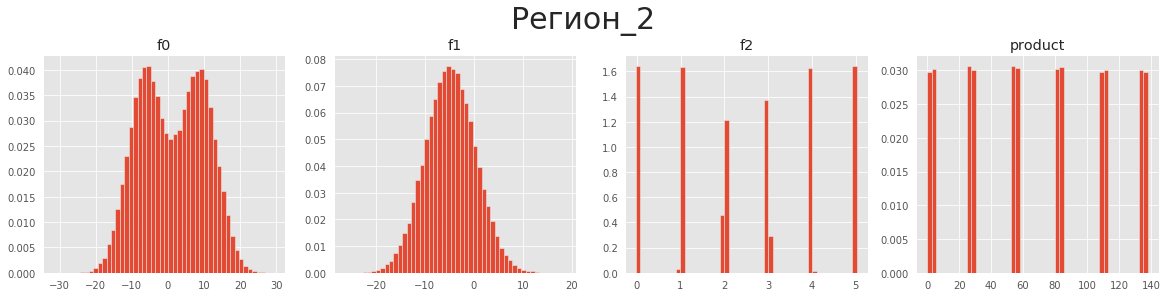

In [6]:
region = 1
num_bins = 50
fig, ax = plt.subplots(1,4, figsize=(20, 4))
fig.suptitle(title_hist[region] ,y = 1.05,fontsize = 30)

for i in range(4):
    ax[i].hist(data_list[region][list_columns[i]], num_bins, density=True);
    ax[i].set_title(list_columns[i])    

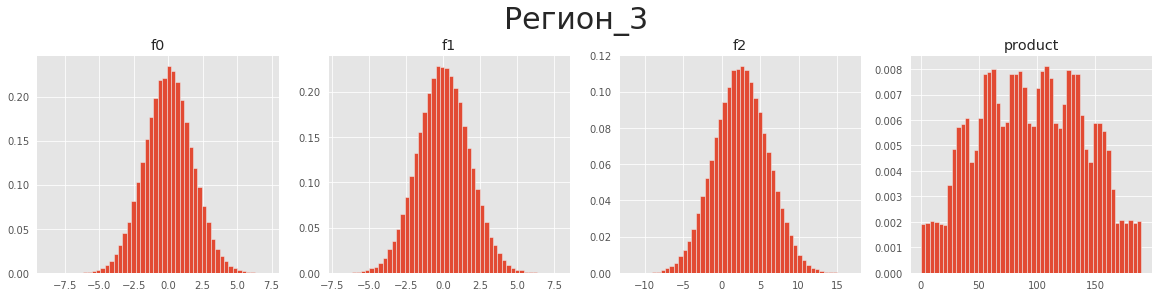

In [7]:
region = 2
num_bins = 50
fig, ax = plt.subplots(1,4, figsize=(20, 4))
fig.suptitle(title_hist[region] ,y = 1.05,fontsize = 30)

for i in range(4):
    ax[i].hist(data_list[region][list_columns[i]], num_bins, density=True);
    ax[i].set_title(list_columns[i])    

**Вывод:**  Распределения достаточно равномерные, но по некоторым признакам наблюдается  мультимодальность. Плюс данные  имеют разный масштаб, требуется масштабирование данных 

### Оценка линейной корреляции данных

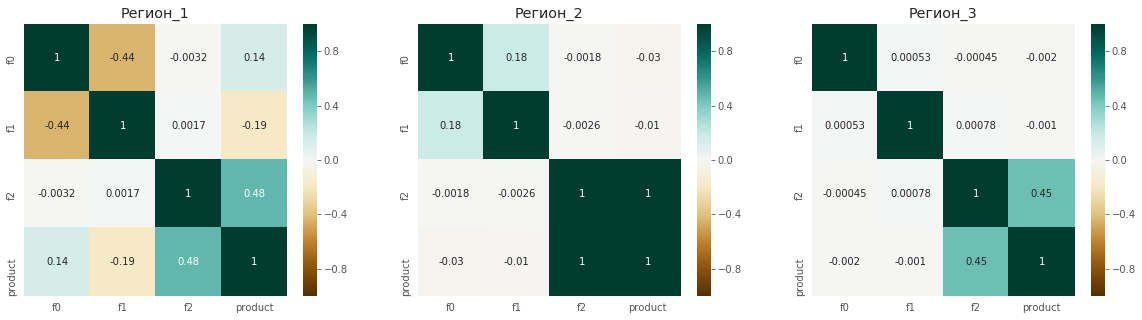

In [8]:
fig, axes = plt.subplots(1, 3,figsize=(20, 5))
title_heatmap = ['Регион_1','Регион_2','Регион_3']
for i in range(3):
    sns.heatmap(data_list[i].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=axes[i])
    axes[i].set_title(title_heatmap[i], loc = 'center')    

**Вывод:** Видны линейные  корреляции в особенности по критерию f2, и в  особенности в регионе 2

## Обучение и проверка модели

По условию задачи необходимо предсказать средний запас сырья, а это задача регрессии. Также по условию задачи подходит только линейная регрессия, так как прочие недостаточно предсказуемы.

### Разделение данных на обучающую и валидационную выборки в соотношении 75:25.

In [9]:
data_train_list = []
data_valid_list = []
for i in range(3):
    exec(f'data_train_{i},data_valid_{i} = train_test_split(data_list[{i}], test_size=0.25, random_state=393)')
    exec(f'data_train_list.append(data_train_{i})')
    exec(f'data_valid_list.append(data_valid_{i})')

In [10]:
for i in range(3):
    print (data_train_list[i].shape)
    print (data_valid_list[i].shape)


(75000, 5)
(25000, 5)
(75000, 5)
(25000, 5)
(75000, 5)
(25000, 5)


**Комментарий:** разбиение корректное

### Выделение целевого  признака Product

In [11]:
for i in range(3):
    exec(f'features_train_{i} = data_train_list[{i}].drop(["product","id"], axis=1)')
    exec(f'features_valid_{i} = data_valid_list[{i}].drop(["product","id"], axis=1)')
    exec(f'target_train_{i} = data_train_list[{i}]["product"]')     
    exec(f'target_valid_{i} = data_valid_list[{i}]["product"]')

### Масштабирование  данных

Так  как работаем с линейной моделью и признаки имеют разный масштаб, то требуется масштабировать данные.

In [12]:
numeric = list_columns[0:3]
scaler = StandardScaler()
for i in range(3):
    exec(f'scaler.fit(features_train_{i}[numeric])')
    exec(f'features_train_{i}[numeric] = scaler.transform(features_train_{i}[numeric])')
    exec(f'features_valid_{i}[numeric] = scaler.transform(features_valid_{i}[numeric])')

### Обучение моделей

Обучим модели и сделаем предсказания на валидационной выборке

In [13]:
def LinearRegression_calculation(features_train,target_train,features_valid,target_valid): 
     
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    
    mean = target_train.mean()
    mse = mean_squared_error(target_valid,predictions_valid)
    r2 = r2_score(target_valid,predictions_valid)
    rmse = mean_squared_error(target_valid,predictions_valid) ** 0.5
    
    predicted_valid = pd.Series(target_train.mean(), index=target_valid.index)
    mean_const_model = target_valid.mean()
    mse_const_model = mean_squared_error(target_valid, predicted_valid)   
    rmse_const_model = mse_const_model**0.5
    
    return mean,mse,r2,rmse,mean_const_model,mse_const_model,rmse_const_model,predictions_valid

Запустим работу функции

In [14]:
list_of_mse = []
list_of_r2 = []
list_of_rmse = []
predict_valid_list =[]
for i in range (3):
    exec(f'mean,mse,r2,rmse,mean_const_model,mse_const_model,rmse_const_model,predictions_valid_{i}=LinearRegression_calculation(features_train_{i},target_train_{i},features_valid_{i},target_valid_{i})')
    list_of_mse.append (mse)
    list_of_r2.append (r2)
    list_of_rmse.append (rmse)
    exec(f'predict_valid_list.append(predictions_valid_{i})')

Отобразим итоги предсказаний 

In [15]:
table_of_region = ['Регион 1','Регион 2','Регион 3']
pivot_table = (pd.DataFrame({'Регион':table_of_region,'Коэффициент детерминации': list_of_r2 ,
                             'Cредняя квадратичная ошибка':list_of_mse,
                             'Квадратный корень из средней квадратичной ошибки':list_of_rmse}))
pivot_table

,Регион,Коэффициент детерминации,Cредняя квадратичная ошибка,Квадратный корень из средней квадратичной ошибки
0,Регион 1,0.27,"1,424.07",37.74
1,Регион 2,1.00,0.79,0.89
2,Регион 3,0.20,"1,604.16",40.05


**Вывод:** Регион 2 коэффициент детерминации почти = 1, это говорит этом что там есть сильная линейная зависимость, это было видно по матрице корреляций. По остальным регионам  LinearRegression достаточно с низким качеством описывает зависимость.

## Подготовка к расчёту прибыли

### Расчет точки безубыточности

In [16]:
break_even_point = BUDGET/NUMBER_WELL/GROSS_INCOME
print ('Точка безубыточности:{:,.2f}'.format(break_even_point))

Точка безубыточности:111.11


Для безубыточной добычи требуются скважины с запасом более более **111,11** тыс .баррелей

### Расчет среднего количества тыс баррелей на одну скважину по регионам

In [17]:
for i in range(3):
    print ('Среденее количество баррелей на одну скважину',title_hist[i],round(data_list[i]['product'].mean(),2))
print ('Необходимое среденее количество баррелей на одну скважину, чтобы  уложиться в бюджет',round(break_even_point,2)) 

Среденее количество баррелей на одну скважину Регион_1 92.5
Среденее количество баррелей на одну скважину Регион_2 68.83
Среденее количество баррелей на одну скважину Регион_3 95.0
Необходимое среденее количество баррелей на одну скважину, чтобы  уложиться в бюджет 111.11


**Вывод:** В среднем, в регионах недостаточно количества баррелей на  одну скважину, чтобы  уложиться в  бюджет

## Расчёт прибыли и рисков 

### Составление  функцию расчета прибыли 
Принцип расчета - сумма по 200 скважинам с максимальным объемом добычи * доход каждой единице продукта составляет  -  бюджет на разработку

In [18]:
def revenue(target, probabilities, number_well):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:number_well]
    return GROSS_INCOME * selected.sum()-BUDGET

In [19]:
target_valid_list = [target_valid_0,target_valid_1,target_valid_2]

for i in range(3):
    exec(f'predict_valid_list[i] = pd.Series(predictions_valid_{i})')
    print ('Предсказания прибыли ТОП 200 скважин по объему сырья',title_hist[i],': {:,.2f}'.format(revenue(target_valid_list[i].reset_index(drop=True),predict_valid_list[i], NUMBER_WELL)))


Предсказания прибыли ТОП 200 скважин по объему сырья Регион_1 : 3,272,699,817.54
Предсказания прибыли ТОП 200 скважин по объему сырья Регион_2 : 2,415,086,696.68
Предсказания прибыли ТОП 200 скважин по объему сырья Регион_3 : 2,704,296,096.60


### Использование  Bootstrap с 1000 выборок, чтобы для нахождения  распределение прибыли

In [20]:
def profit_calculation(target_valid,predict_valid):
    state = np.random.RandomState(393)
    profit = []
    for i in range(1000):
        target_sample = target_valid.sample(SEARCH_WELL,replace=True, random_state=state)
        probs_sample = pd.Series(predict_valid)[target_sample.index]
        profits = revenue(target_sample, probs_sample, NUMBER_WELL)
        profit.append(profits)
   
    profit = pd.Series(profit)
    mean_profit = profit.mean()
    lower_edge = profit.quantile(0.025)
    upper_edge = profit.quantile(0.975)
    
    losses = profit[profit < 0]
    loss_probaility = len(losses) / len(profit)
    
    return mean_profit,upper_edge,lower_edge,loss_probaility#confidence_interval

### Расчет показатели распредения прибыли по регионам

In [21]:
profit_mean_list=[]
loss_probaility_list=[]
lower_edge_list=[]
upper_edge_list =[]
for i in range(3):
    exec(f'mean_profit,upper_edge,lower_edge, loss_probaility = profit_calculation(target_valid_{i}.reset_index(drop=True),predictions_valid_{i})')
    profit_mean_list.append(mean_profit)
    loss_probaility_list.append(loss_probaility)
    lower_edge_list.append(lower_edge)
    upper_edge_list.append(upper_edge)

In [22]:
table_of_region = ['Регион 1','Регион 2','Регион 3']
pivot_table_final = (pd.DataFrame({'Регион':table_of_region,'Средняя прибыль, руб.': profit_mean_list ,
                                   'Риск убытков':loss_probaility_list,
                                   'Нижняя граница довертильного интервала, руб.': lower_edge_list,
                                   'Верхняя граница довертильного интервала, руб.': upper_edge_list}))
pivot_table_final.style.format({'Средняя прибыль, руб.':'{:,.2f}',
                                'Риск убытков': '{:.2%}',
                                'Нижняя граница довертильного интервала, руб.':'{:,.2f}',
                                'Верхняя граница довертильного интервала, руб.': '{:,.2f}'})


,Регион,"Средняя прибыль, руб.",Риск убытков,"Нижняя граница довертильного интервала, руб.","Верхняя граница довертильного интервала, руб."
0,Регион 1,"447,014,792.83",5.70%,"-96,158,554.36","966,896,718.98"
1,Регион 2,"508,103,815.94",1.10%,"88,136,513.70","917,963,147.70"
2,Регион 3,"421,089,889.29",7.30%,"-123,018,699.31","977,865,666.86"


# Вывод: 
Исходя из прогнозируемой средней прибыли целесообразно вкладываться в разработку скважин. Наиболее интересным с точки зрения соотношения риск- прибыль является регион номер 2.  

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован